# 📝 IBM HR 분석: 직원 이직 및 성과 
### (IBM HR Analytics Employee Attrition & Performance)

- ⭐목표: 직원 이직 여부를 예측하는 모델을 구축하고, 직원의 이직 원인과 관련된 인사이트를 도출<br>
- ⭐예상 결과: 모델을 통해 향후 이직할 가능성이 있는 직원을 예측하고 조직의 인사 전략 대응 및 개선 방향
- ⭐아키텍처 정의: 데이터 수집, 데이터 처리, 데이터분석, 시각화, 머신러닝 모델링생성 및 평가
- ⭐개발 및 환경 구축: 
     - PySpark 의한 데이터 처리
     - Python 데이터 분석 및 머신모델을 위한 언어
     - Pandas
     - Jupyter Notebook 코드 실행 및 결과 확인을 위한 인터페이스
     - AWS EC2 클라우드 환경 사용
     - GitHub: 코드 백업

- ⭐계발 계획
    1. 데이터수집
    2. 데이터 전처리
    3. 탐색적 데이터 분석 (EDA) 
    4. 머신러닝 모델링
        - 모델링 접근: 종속변수(Attrition, YES or NO)가 이진(binary) 형태여서 Logistic Regression 분석
        - 이직 여부와 각 독립 변수 간의 관계를 파악
        - 테스트 계획: 훈련 데이터와 테스트 데이터를 나누어 모델 성능 테스트 
- ⭐데이터 출처: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data


# 1. 데이터수집

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Employee_Attrition").getOrCreate()
spark

24/12/20 16:42:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header",'true')\
    .option('inferSchema', 'true')\
    .load("data/HR-Employee-Attrition.csv")

In [3]:
#필요한 라이브러리 불러오기 

from pyspark.sql.functions import *
from pyspark.ml import *
from pyspark.ml.feature import *
from pyspark.ml.recommendation import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *
from pyspark.sql.types import *
from pyspark.ml.stat import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 1.1 데이터 구조 확인

In [4]:
# 얼마나 많은 열이 있는지 확인
df.count()

1470

In [5]:
# 컬럼 확인
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

In [6]:
df.show(3)

24/12/20 16:42:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

## 1.2 컬럼 설명

- Age: 직원의 나이
- Attrition: 직원의 이직 여부 (Yes or No)
- BusinessTravel: 직원의 출장 빈도 (Non-Travel, Travel_Rarely, Travel_Frequently)
- DailyRate: 직원의 일일 급여
- Department: 직원이 속한 부서 (Research & Development, Sales, Human Resources)
- DistanceFromHome: 직원의 집으로부터 회사까지의 거리
- Education: 직원의 학력 수준 (1: Below College, 2: College, 3: Bachelor, 4: Master, 5: Doctor)
- EducationField: 직원의 전공 분야
- EmployeeCount: 직원 수 (모든 값이 1로 동일)
- EmployeeNumber: 직원의 고유 번호
- EnvironmentSatisfaction: 직원의 업무 환경 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- Gender: 직원의 성별 (Male, Female)
- HourlyRate: 직원의 시간당 급여
- JobInvolvement: 직원의 직무 참여도 (1: Low, 2: Medium, 3: High, 4: Very High)
- JobLevel: 직원의 직급
- JobRole: 직원의 직무
- JobSatisfaction: 직원의 직무 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 직원의 결혼 여부 (Single, Married, Divorced)
- MonthlyIncome: 직원의 월급
- MonthlyRate: 직원의 월별 급여 총액
- NumCompaniesWorked: 직원이 근무한 회사 수
- Over18: 직원이 18세 이상인지 여부 (모든 값이 Y로 동일)
- OverTime: 직원의 초과 근무 여부 (Yes, No)
- PercentSalaryHike: 직원의 급여 인상 비율
- PerformanceRating: 직원의 성과 평가 등급 (1: Low, 2: Good, 3: Excellent, 4: Outstanding)
- RelationshipSatisfaction: 직원의 동료와의 관계 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- StandardHours: 직원의 표준 근무 시간 (모든 값이 80으로 동일)
- StockOptionLevel: 직원의 주식 옵션 수준 (0, 1, 2, 3)
- TotalWorkingYears: 직원의 총 근무 연수
- TrainingTimesLastYear: 지난해 직원이 받은 교육 횟수
- WorkLifeBalance: 직원의 일-생활 균형 만족도 (1: Bad, 2: Good, 3: Better, 4: Best)
- YearsAtCompany: 직원이 현재 회사에서 근무한 기간
- YearsInCurrentRole: 직원이 현재 역할에서 근무한 기간
- YearsSinceLastPromotion: 직원의 마지막 승진 이후 경과된 기간
- YearsWithCurrManager: 직원이 현재 관리자와 함께 일한 기간

# 2. 데이터 전처리

In [7]:
#각 컬럼별 null 값 개수 확인
null_counts = df.select(
    [
    sum(when(col(c).isNull() | isnan(c),1).otherwise(0)).alias(c) for c in df.columns
    ]
)

null_counts.show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [8]:
# 중복 데이터 확인
df.groupBy(df.columns).count().filter(col("count") > 1).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSince

## 2.1 불필요한 컬럼 제거 

- EmployeeNumber 직원 고유번호라 불필요
- EmployeeCount, Over18, StandardHours : 단일 값만 가짐
- DailyRate, HourlyRate, MonthlyRate 은 MonthlyIncome을 대체로 사용할 수 있어서 불필요 


In [9]:
df = df.drop("EmployeeNumber","EmployeeCount", "Over18", "StandardHours", "DailyRate", "HourlyRate", "MonthlyRate")
df.show(5)

+---+---------+-----------------+--------------------+----------------+---------+--------------+-----------------------+------+--------------+--------+--------------------+---------------+-------------+-------------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+-----------------+--------------------+----------------+---------+---

# 3. 탐색적 데이터 분석 (EDA)

## 3.1 범주형 데이터 

In [10]:
string_cols = [
    "Attrition", "BusinessTravel","Department", "EducationField",
    "Gender", "JobRole", "MaritalStatus", "OverTime"
]
for col in string_cols:
    df.groupBy(col).count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+-----------------+-----+
|   BusinessTravel|count|
+-----------------+-----+
|Travel_Frequently|  277|
|       Non-Travel|  150|
|    Travel_Rarely| 1043|
+-----------------+-----+

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|               Sales|  446|
|Research & Develo...|  961|
|     Human Resources|   63|
+--------------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|Technical Degree|  132|
|           Other|   82|
|       Marketing|  159|
|         Medical|  464|
|   Life Sciences|  606|
| Human Resources|   27|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  588|
|  Male|  882|
+------+-----+

+--------------------+-----+
|             JobRole|count|
+--------------------+-----+
|     Sales Executive|  326|
|Manufacturing Dir...|  145|
|Laboratory Techn

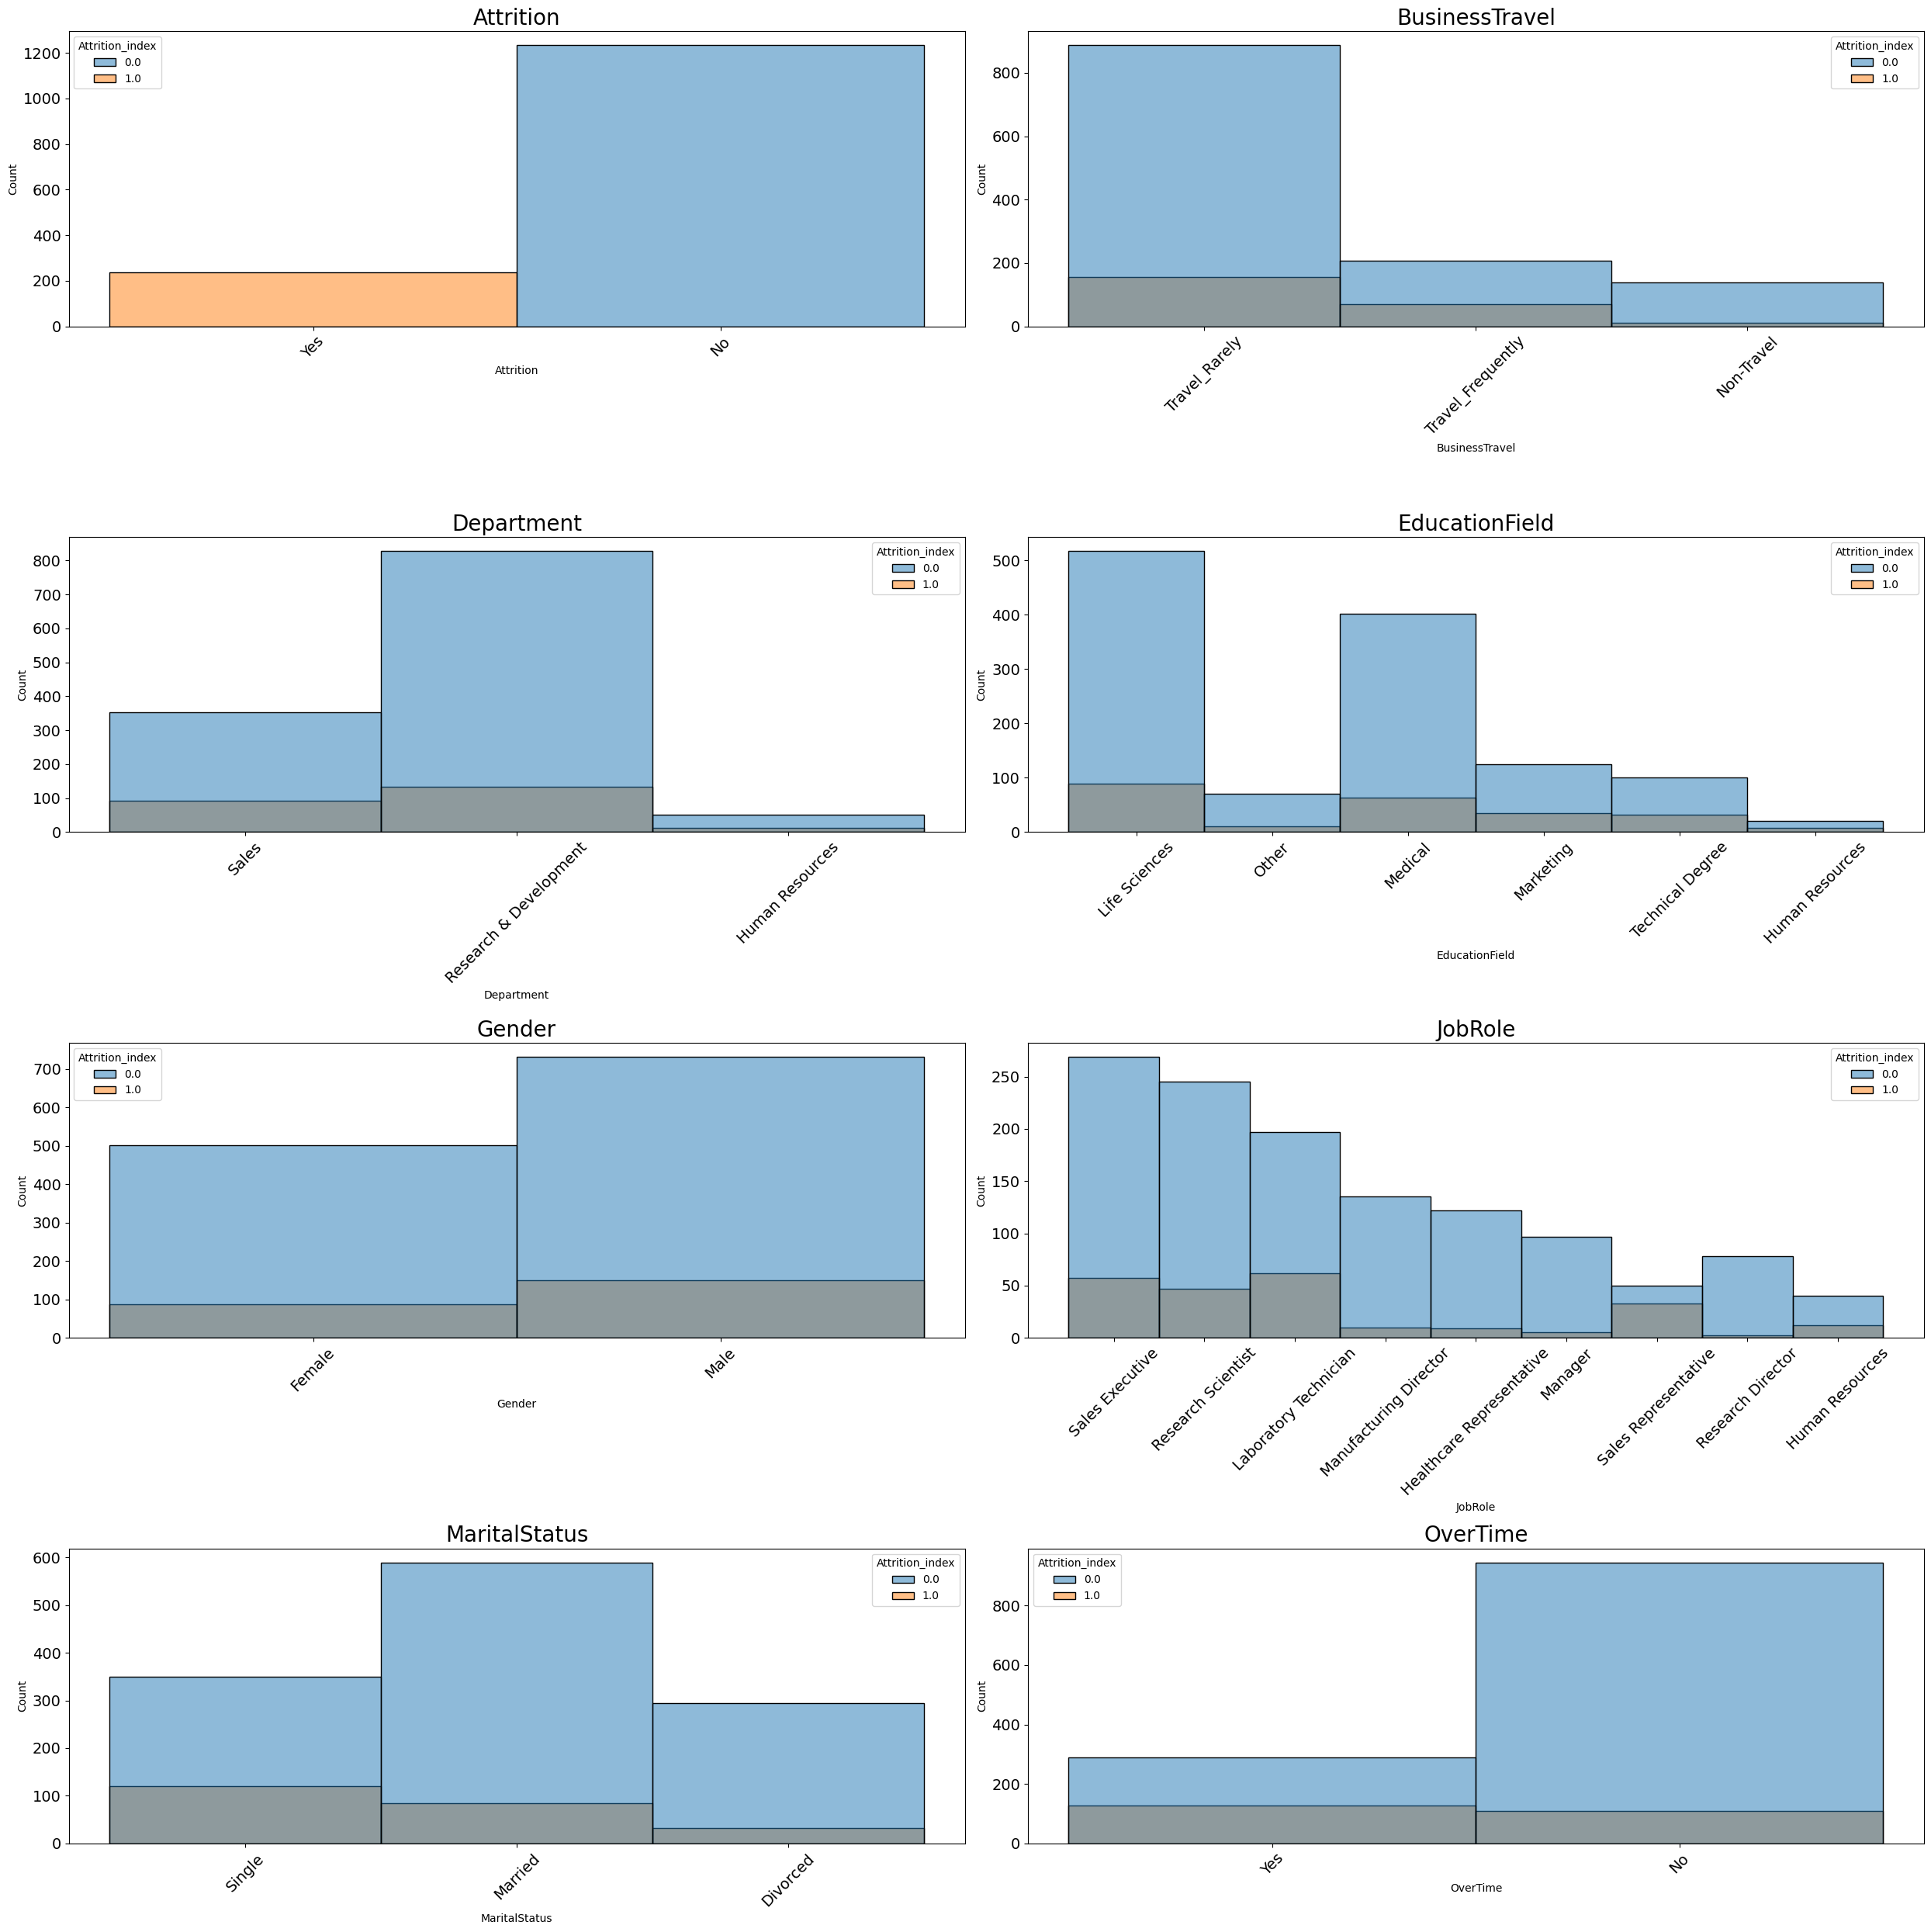

In [11]:
# 'Attrition'을 수치형으로 변환
indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
df_indexed = indexer.fit(df).transform(df)

# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *string_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(4,2, figsize=(25, 25))
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(string_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=20)  
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.show()

## 3.2 수치형 데이터

In [12]:
numeric_cols = [
    "Age", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears",
    "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany",
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]

for col in numeric_cols:
    df.groupBy(col).count().show()

+---+-----+
|Age|count|
+---+-----+
| 31|   69|
| 53|   19|
| 34|   77|
| 28|   48|
| 27|   48|
| 26|   39|
| 44|   33|
| 22|   16|
| 47|   24|
| 52|   18|
| 40|   57|
| 20|   11|
| 57|    4|
| 54|   18|
| 48|   19|
| 19|    9|
| 41|   40|
| 43|   32|
| 37|   50|
| 35|   78|
+---+-----+
only showing top 20 rows

+----------------+-----+
|DistanceFromHome|count|
+----------------+-----+
|              28|   23|
|              27|   12|
|              26|   25|
|              12|   20|
|              22|   19|
|               1|  208|
|              13|   19|
|              16|   32|
|               6|   59|
|               3|   84|
|              20|   25|
|               5|   65|
|              19|   22|
|              15|   26|
|               9|   85|
|              17|   20|
|               4|   64|
|               8|   80|
|              23|   27|
|               7|   84|
+----------------+-----+
only showing top 20 rows

+---------+-----+
|Education|count|
+---------+-----+
|     

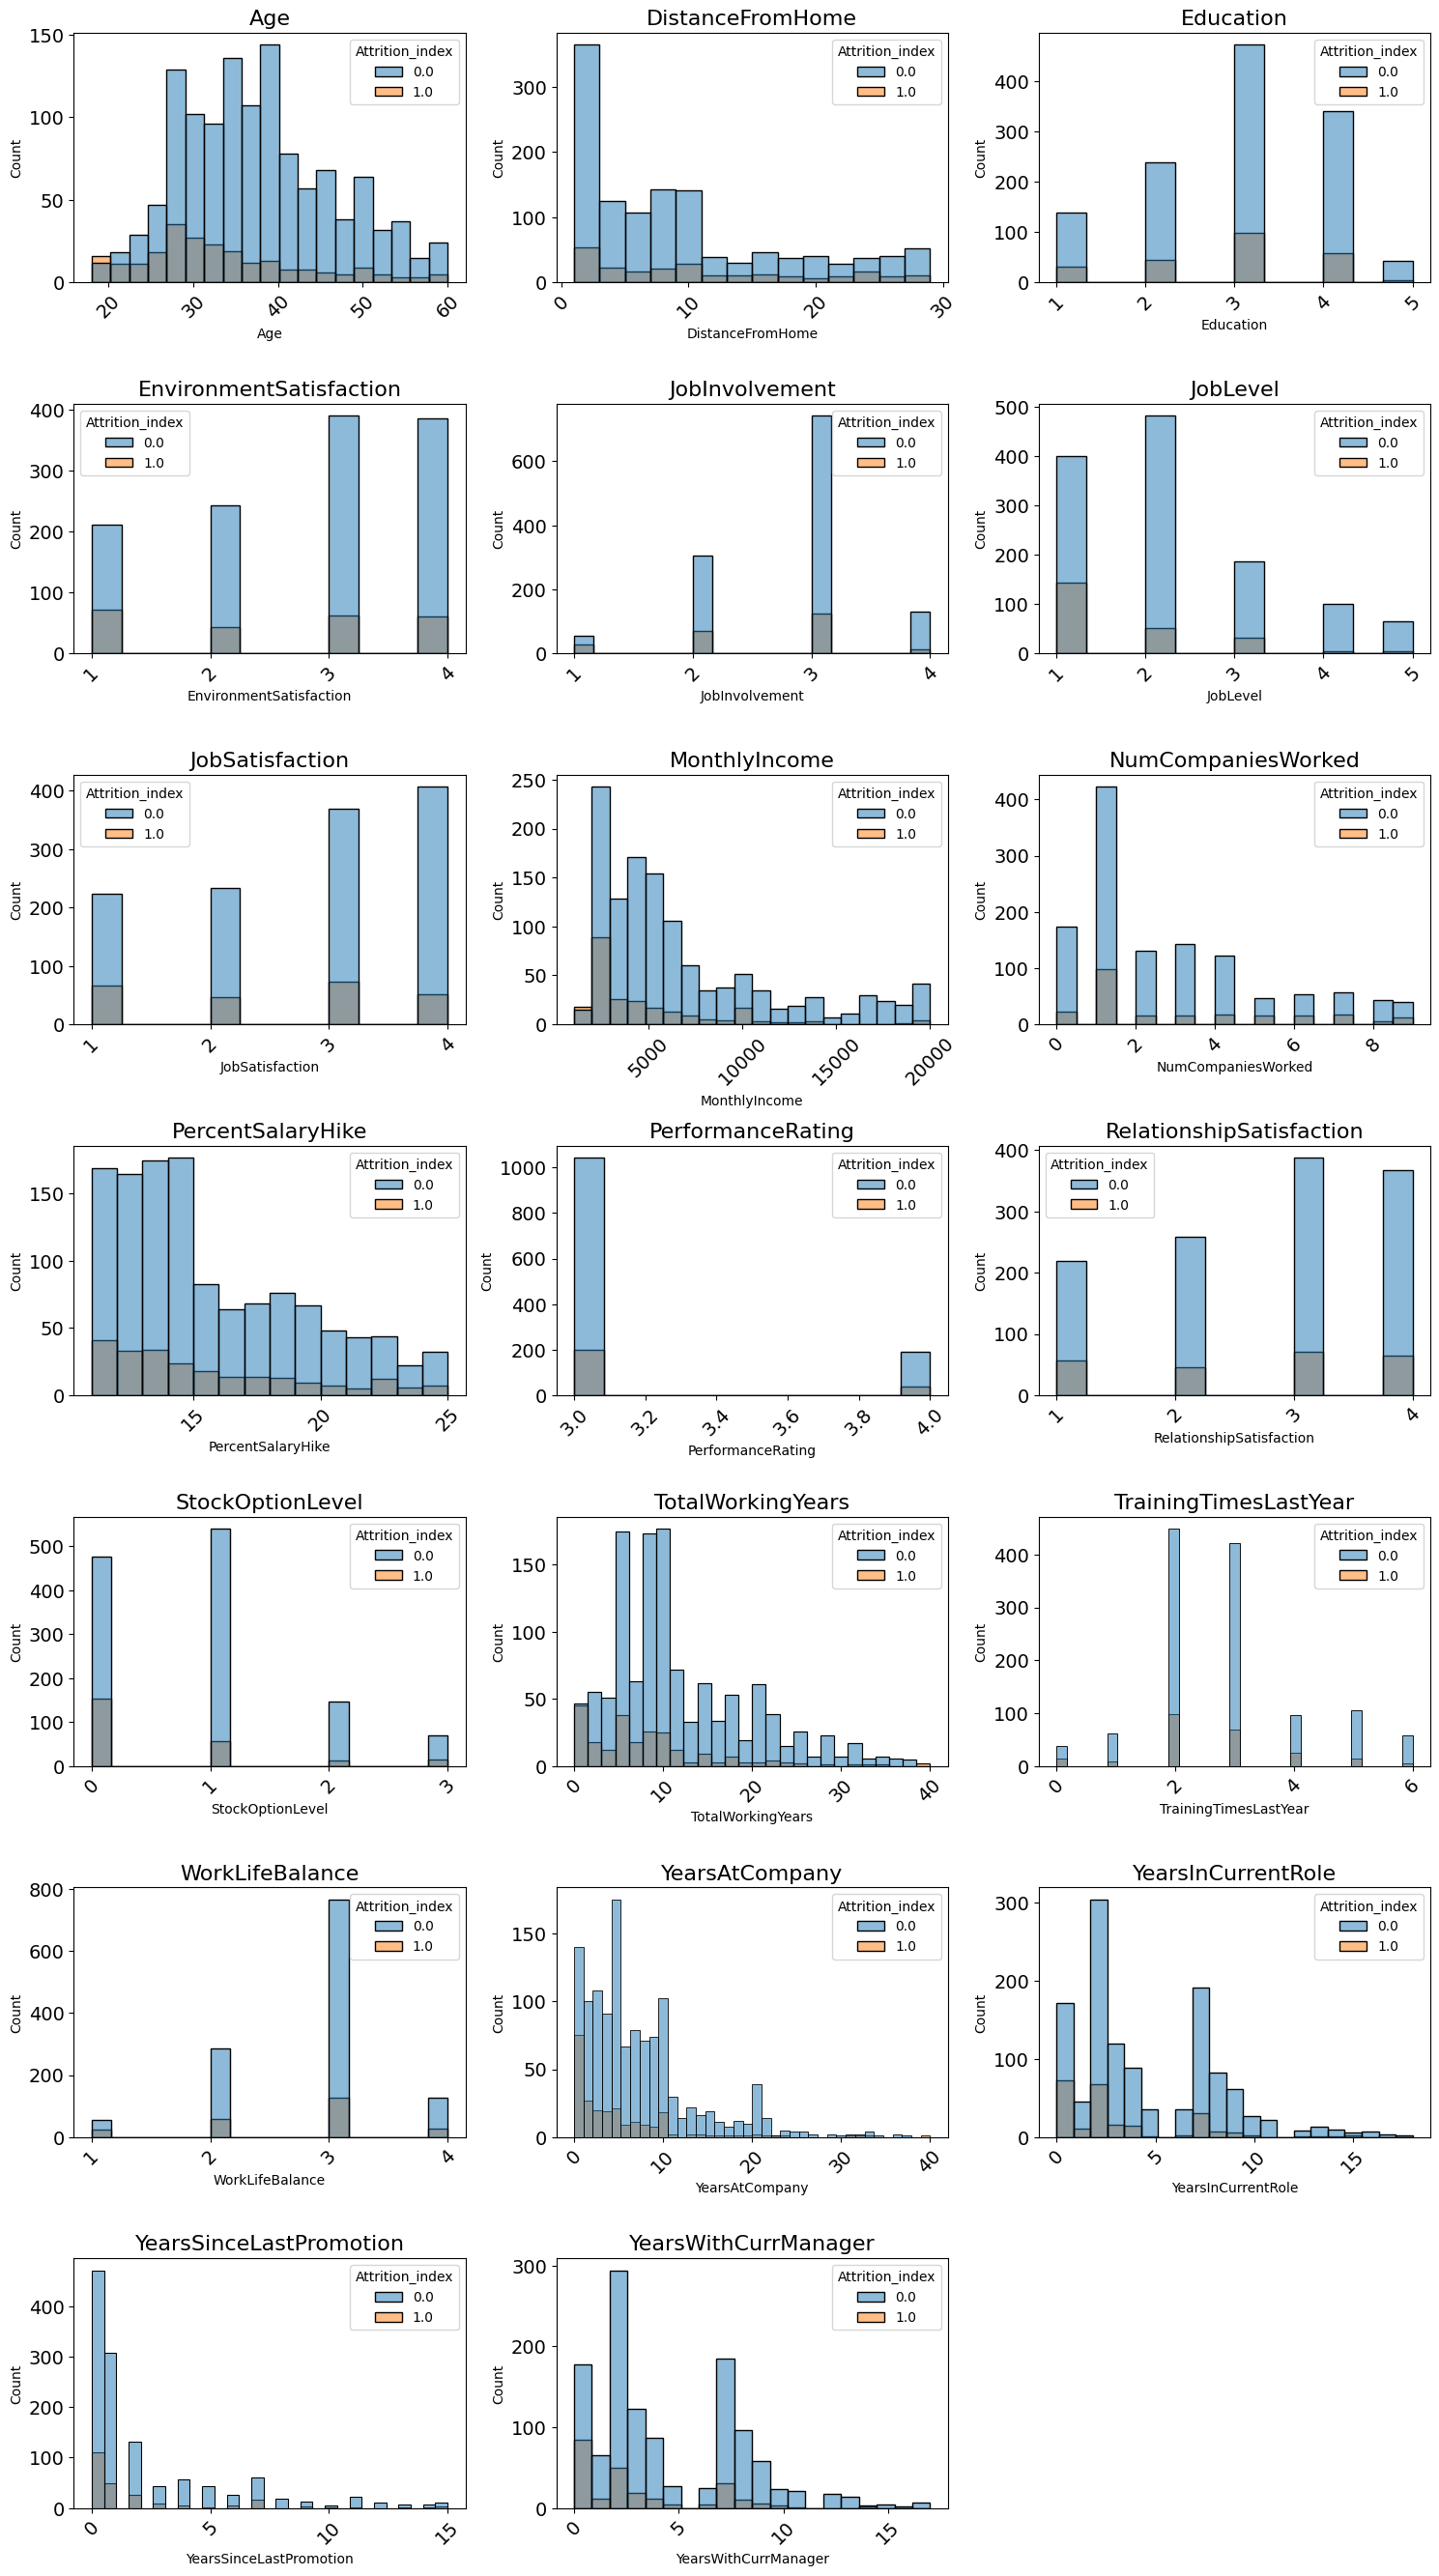

In [13]:
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *numeric_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(8,3, figsize=(15, 30))
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=16)
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=14)  
    axes[i].tick_params(axis='y', labelsize=14)

# 남는 서브플롯 제거
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### ✏️ 전체적인 데이터 분석 - 어떤 그룹에 퇴직자들이 많을까? 
- 나이: 30 이전의 그룹에서 퇴직자가 많이 발생
- 근속 연수: 10년 이하인 직원들이 퇴직률이 높음

🔍연령대와 근속 연수를 범주화해서 더 구체적인 분석이 필요
- 퇴직 이유 파악, 직무 만족도, 업무 환경 등을 추가로 분석하여 퇴직을 예방

## 3.3 상세 분석

### 3.3.1 나이 분석

In [14]:
from pyspark.sql.functions import when, col

# 나이 범위 지정
df = df.withColumn(
    "AgeGroup",
    when(col("Age") < 30, "20s")
    .when((col("Age") >= 30) & (col("Age") < 40), "30s")
    .when((col("Age") >= 40) & (col("Age") < 50), "40s")
    .when((col("Age") >= 50) & (col("Age") < 60), "50s")
    .otherwise("60s+")
)

#나이 그룹별 이직 여부 
df_age_group = df.groupBy("AgeGroup", "Attrition").count().orderBy("AgeGroup")

#피벗 테이블 
age_group_pivot = df_age_group.groupBy("AgeGroup").pivot("Attrition").agg({"count": "sum"})

# null 값을 0으로 처리
age_group_pivot = age_group_pivot.fillna(0, subset=["Yes", "No"])

age_group_pivot = age_group_pivot.withColumn(
    "AttritionRate", col("Yes") / (col("No") + col("Yes"))
).orderBy("AgeGroup")
age_group_pivot.show()

+--------+---+---+-------------------+
|AgeGroup| No|Yes|      AttritionRate|
+--------+---+---+-------------------+
|     20s|235| 91| 0.2791411042944785|
|     30s|533| 89|0.14308681672025725|
|     40s|315| 34|0.09742120343839542|
|     50s|145| 23|0.13690476190476192|
|    60s+|  5|  0|                0.0|
+--------+---+---+-------------------+



/tmp/ipykernel_24292/3925444769.py:7: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_age_pandas, x="AgeGroup", y="AttritionRate", palette="Set3")


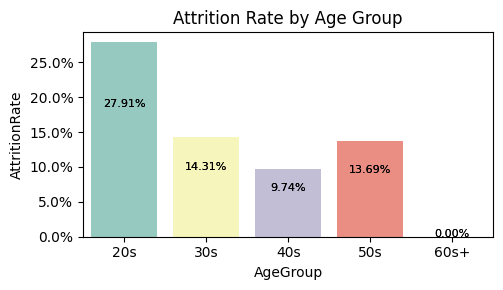

In [15]:
# 시각화
df_age_pandas = age_group_pivot.toPandas()

plt.figure(figsize=(5,3))
ax = sns.barplot(x="AgeGroup", y="AttritionRate", data=df_age_pandas)

sns.barplot(data = df_age_pandas, x="AgeGroup", y="AttritionRate", palette="Set3")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height *2/3, f'{height*100:.2f}%', ha='center', fontsize=8)
plt.title("Attrition Rate by Age Group")
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.show()

### 3.3.2 근속연수 분석

In [16]:
from pyspark.sql import functions as F
# YearsAtCompany 범주화
df = df.withColumn(
    "YearsAtCompanyGroup",
    when(col("YearsAtCompany") < 5, "0-5 years")
    .when((col("YearsAtCompany") >= 5) & (col("YearsAtCompany") < 10), "5-10 years")
    .when((col("YearsAtCompany") >= 10) & (col("YearsAtCompany") < 20), "10-20 years")
    .otherwise("20+ years")
)

# 범주화된 YearsAtCompany 그룹별 이직 여부
df_grouped = df.groupBy("YearsAtCompanyGroup", "Attrition").count()

# 피벗 테이블 생성
df_yearsatcompany_pivot = df_grouped.groupBy("YearsAtCompanyGroup").pivot("Attrition").agg({"count": "sum"})

# Null 값을 0으로 처리
df_yearsatcompany_pivot = df_yearsatcompany_pivot.fillna(0, subset=["Yes", "No"])

# 이직률 계산
df_yearsatcompany_pivot = df_yearsatcompany_pivot.withColumn(
    "AttritionRate", col("Yes") / (col("No") + col("Yes"))
).orderBy(F.desc("Yes"))

df_yearsatcompany_pivot.show()

+-------------------+---+---+-------------------+
|YearsAtCompanyGroup| No|Yes|      AttritionRate|
+-------------------+---+---+-------------------+
|          0-5 years|439|141|0.24310344827586206|
|         5-10 years|466| 58|0.11068702290076336|
|        10-20 years|244| 29|0.10622710622710622|
|          20+ years| 84|  9| 0.0967741935483871|
+-------------------+---+---+-------------------+



/tmp/ipykernel_24292/3219768678.py:5: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='YearsAtCompanyGroup', y='AttritionRate', data=df_years_pandas, palette='Set3')


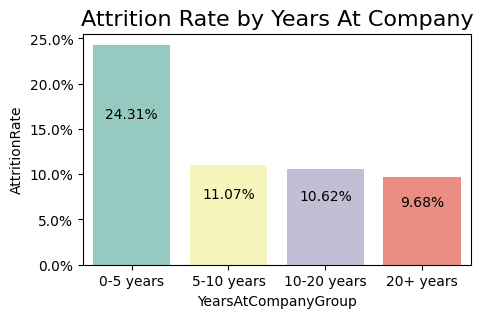

In [17]:
# 시각화
df_years_pandas = df_yearsatcompany_pivot.toPandas()

plt.figure(figsize=(5, 3))
ax = sns.barplot(x='YearsAtCompanyGroup', y='AttritionRate', data=df_years_pandas, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height *2/3, f'{height*100:.2f}%', ha='center')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.title('Attrition Rate by Years At Company', fontsize=16)
plt.show()

✏️ 주요 퇴직 그룹: 퇴직자는 특히 20대에서 높은 퇴직률을 보인다. <br>
✏️ 근속 연수: 경력이 짧은 0-5년 구간에서 다른 구간과 2배 이상 차이가 나며 퇴직자가 가장 많다.  

### 3.3.3 타겟 선정

🔍 타겟 : 퇴사자중 20대의 근속 연수가 0-5년인 그룹이 퇴직자가 많은 이유가 뭘까?<br>
<br>
❓ 가설: 업무 만족도(JobSatisfaction)가 낮아서? 왜 낮을까? 급여? 환경? <br> 
❓ 가설: 월급(MonthlyIncome)이 낮아서? 그럼 급여 인상 비율(Percent Salary Hike)은? <br>
❓ 가설: 다른 요인은? OverTime(초과 근무), StockOptionLevel(주식 옵션)<br>

In [18]:
# 타겟 선정
from pyspark.sql.functions import when, col

# 20대이고 근속 연수가 0-5년인 그룹 필터링
target_group = df.filter(
    (col("AgeGroup") == "20s") & (col("YearsAtCompanyGroup") == "0-5 years")) # & (col("Attrition") == "Yes"

# 분석할 변수들 추출
target_group = target_group.select("JobSatisfaction", "MonthlyIncome", "OverTime", "StockOptionLevel", "Attrition","PercentSalaryHike")

### 3.3.4 가설 : JobSatisfaction 업무 만족도 vs Attrition 직원 이직 여부

In [19]:
#퇴사자 안에서 이직률
job_satisfaction_attrition = target_group.groupBy("JobSatisfaction", "Attrition").count()
job_satisfaction = job_satisfaction_attrition.groupBy("JobSatisfaction").pivot("Attrition").agg(F.sum("count"))

# Attrition 비율 계산
job_satisfaction = job_satisfaction.withColumn(
    "AttritionRate", col("Yes") / (col("No") + col("Yes"))
).orderBy("JobSatisfaction")

job_satisfaction.show()

+---------------+---+---+-------------------+
|JobSatisfaction| No|Yes|      AttritionRate|
+---------------+---+---+-------------------+
|              1| 16| 19| 0.5428571428571428|
|              2| 24| 15|0.38461538461538464|
|              3| 39| 19| 0.3275862068965517|
|              4| 41| 17|0.29310344827586204|
+---------------+---+---+-------------------+



/tmp/ipykernel_24292/2755275985.py:12: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="JobSatisfactionLabel", y="AttritionRate", data=job_satisfaction_pd, palette="Set3", order=['Low', 'Medium', 'High', 'Very High'])


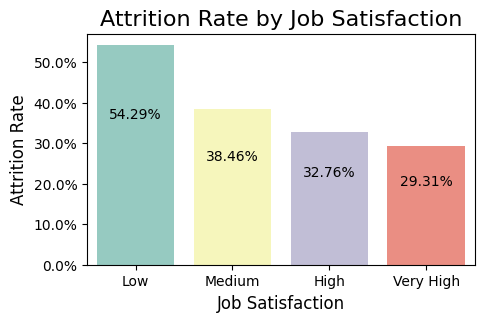

In [20]:
# 시각화
job_satisfaction_pd = job_satisfaction.toPandas()

job_satisfaction_pd['JobSatisfactionLabel'] = job_satisfaction_pd['JobSatisfaction'].map({
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High'
})

plt.figure(figsize=(5, 3))
ax = sns.barplot(x="JobSatisfactionLabel", y="AttritionRate", data=job_satisfaction_pd, palette="Set3", order=['Low', 'Medium', 'High', 'Very High'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height *2/3, f'{height*100:.2f}%', ha='center')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.title("Attrition Rate by Job Satisfaction", fontsize=16)
plt.xlabel("Job Satisfaction", fontsize=12)
plt.ylabel("Attrition Rate", fontsize=12)
plt.show()

✏️ 1점 (Low): 이직률이 **54.29%**로 가장 높다. <BR> 이 그룹은 가장 높은 퇴사율을 기록하며, 업무 만족도가 매우 낮은 사람들이 많이 이직하는 경향<BR><BR>
🔍 낮은 업무 만족도 이유는 무엇인가??

In [21]:
# 상관관계

#수치화
target_group = target_group.withColumn(
    "OverTime", 
    F.when(F.col("OverTime") == "Yes", 1).otherwise(0).cast("int"))
target_group = target_group.withColumn(
    "Attrition", 
    F.when(F.col("Attrition") == "Yes", 1).otherwise(0).cast("int"))

target_group_pandas = target_group.toPandas()

correlation_matrix = target_group_pandas.corr()
job_satisfaction_corr = correlation_matrix["JobSatisfaction"].sort_values(ascending=False)
print(job_satisfaction_corr)

JobSatisfaction      1.000000
MonthlyIncome        0.080719
StockOptionLevel     0.062706
OverTime             0.024100
PercentSalaryHike   -0.009356
Attrition           -0.173211
Name: JobSatisfaction, dtype: float64


✏️ Attrition (-0.173211) 업무 만족도와 이직 여부(Attrition):<BR>업무 만족도가 낮을수록 이직 확률이 높다는 경향<BR>
✏️ MonthlyIncome (0.080719) 업무 만족도와 월급 간의 상관 관계 : <BR>월급이 높은 사람은 업무 만족도가 약간 높을 가능성<BR>
✏️ StockOptionLevel (0.062706) 업무 만족도와 주식 옵션 수준 : <BR>주식 옵션 수준이 높을수록 업무 만족도가 약간 높아질 수 있음<BR>


### 3.3.5 가설 : MonthlyIncome 월급 vs Attrition 직원 이직 여부

+---------+--------------------+
|Attrition|AverageMonthlyIncome|
+---------+--------------------+
|        1|              2704.6|
|        0|   3084.266666666667|
+---------+--------------------+



/tmp/ipykernel_24292/814052051.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Attrition', y='MonthlyIncome', data=target_group_pandas, palette='Set3', order=["Yes","No"])


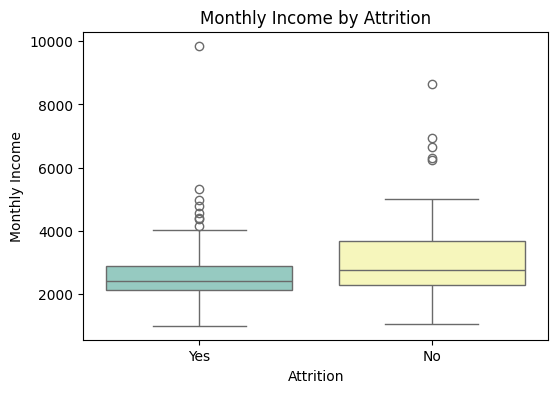

In [24]:
# MonthlyIncome의 이직 여부에 따른 평균 비교
target_group.groupBy("Attrition").agg(avg("MonthlyIncome").alias("AverageMonthlyIncome")).show()

# 시각화
target_group_pandas = target_group.toPandas()
target_group_pandas['Attrition'] = target_group_pandas['Attrition'].map({1: 'Yes', 0:'No'})

plt.figure(figsize=(6, 4))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=target_group_pandas, palette='Set3', order=["Yes","No"])

plt.title('Monthly Income by Attrition')
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

✏️ 퇴직자의 월급은 중앙값이 2000-3000 사이로 재직자의 중앙값 (4000) 보다 **1000+** 낮고, 분포가 좁으며 4000 이하에 집중되었다. 눈에 띄는 이상치가 발견되지만 극히 적다. <br>
✏️퇴직자와 재직자 평균 월급을 비교 했을때 이직한 직원의 월급이 약 **350** 정도 더 낮다. <br><br>
🔍 월급은 퇴직자가 재직자에 비해 낮게 받는 성향이 있다. 그러면 PercentSalaryHike, 직원의 급여 인상 비율이 높으면 괜찮나?

+-----------------+----+---+-------------------+
|PercentSalaryHike|  No|Yes|      AttritionRate|
+-----------------+----+---+-------------------+
|               11|  14| 11|               0.44|
|               12|  14|  7| 0.3333333333333333|
|               13|  17| 12|0.41379310344827586|
|               14|  22|  7| 0.2413793103448276|
|               15|  10|  5| 0.3333333333333333|
|               16|   6|  3| 0.3333333333333333|
|               17|   4|  5| 0.5555555555555556|
|               18|  10|  4| 0.2857142857142857|
|               19|   9|  6|                0.4|
|               20|   1|  3|               0.75|
|               21|   3|  3|                0.5|
|               22|   6|  1|0.14285714285714285|
|               23|null|  1|               null|
|               24|   2|  1| 0.3333333333333333|
|               25|   2|  1| 0.3333333333333333|
+-----------------+----+---+-------------------+



/tmp/ipykernel_24292/96529238.py:15: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="PercentSalaryHike",y="AttritionRate", data=salary_hike_pd, palette="Set3")


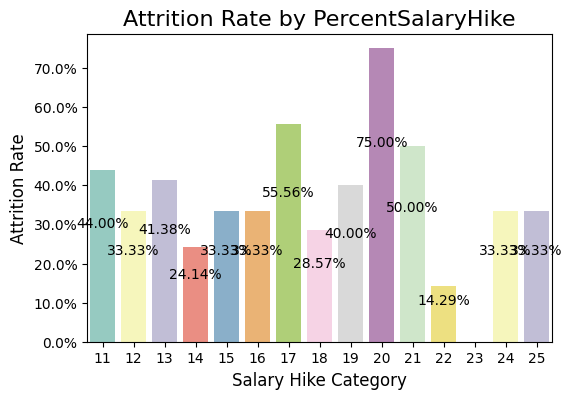

In [28]:
# 직원의 급여 인상 비율 PercentSalaryHike

# 이직률 비교
salary_hike_attrition = target_group.groupBy("PercentSalaryHike", "Attrition").count()
salary_hike = salary_hike_attrition.groupBy("PercentSalaryHike").pivot("Attrition").agg(F.sum("count"))
salary_hike = salary_hike.withColumnRenamed("1", "Yes").withColumnRenamed("0", "No")
salary_hike = salary_hike.withColumn(
    "AttritionRate", col("Yes") / (col("No") + col("Yes"))
).orderBy("PercentSalaryHike")
salary_hike.show()

# 시각화
salary_hike_pd = salary_hike.toPandas()
plt.figure(figsize=(6, 4))
ax = sns.barplot(x="PercentSalaryHike",y="AttritionRate", data=salary_hike_pd, palette="Set3")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height * 2 / 3, f'{height * 100:.2f}%', ha='center')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.title("Attrition Rate by PercentSalaryHike", fontsize=16)
plt.xlabel("Salary Hike Category", fontsize=12)
plt.ylabel("Attrition Rate", fontsize=12)
plt.show()


✏️ 월급이 낮은 대신 급여 인상 비율이라도 높으면 이직률이 낮을까? 라는 기대로 분석해 보았지만 급여 인상 비율이 낮은 경우(11~13%), 이직률은 상대적으로 높으나(최대 44%) 오히려 급여 인상 비율이 매우 높은 경우 (20% 이상) 이직률이 증가하는 패턴(최대 75%)을 보이므로 단순히 급여 인상 비율만으로는 이직률을 예측하기 어렵다는 것. <br>

🔍 적정 수준의 급여 인상이 직원 유지에 긍정적 영향을 미칠 수 있지만, 지나치게 높은 급여 인상이 항상 낮은 이직률로 이어지지는 않는다고 판단! 이는 급여 외 다른 요인도 중요한 역할을 한다는 점을 시사함. 추가로 재직자/퇴직자에서 가장 많은 비율차를 보였던 OverTIme 야근과 StockOptionLevel 주식옵션수준을 분석해보기로 함! 

### 3.3.6 가설 : OverTime 초과근무, StockOptionLevel 주식옵션  vs Attrition 이직 여부

+--------+---+---+-------------------+
|OverTime| No|Yes|      AttritionRate|
+--------+---+---+-------------------+
|       1| 17| 36| 0.6792452830188679|
|       0|103| 34|0.24817518248175183|
+--------+---+---+-------------------+



/tmp/ipykernel_24292/3383210461.py:11: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="OverTime", y="AttritionRate", data=overtime_pandas, palette="Set3")


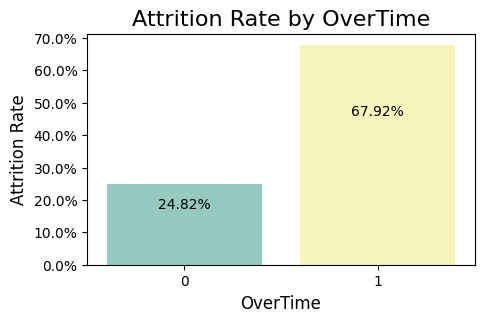

In [43]:
overtime_group = target_group.groupBy("OverTime", "Attrition").count()
overtime_pivot = overtime_group.groupBy("OverTime").pivot("Attrition").agg(F.sum("count"))
overtime_pivot = overtime_pivot.withColumnRenamed("1", "Yes").withColumnRenamed("0", "No")
overtime_pivot = overtime_pivot.withColumn(
    "AttritionRate", col("Yes") / (col("Yes") + col("No")))
overtime_pivot.show()

overtime_pandas = overtime_pivot.toPandas()
# 시각화
plt.figure(figsize=(5, 3))
ax = sns.barplot(x="OverTime", y="AttritionRate", data=overtime_pandas, palette="Set3")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height * 2 / 3, f'{height * 100:.2f}%', ha='center', va='bottom')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.title("Attrition Rate by OverTime", fontsize=16)
plt.xlabel("OverTime", fontsize=12)
plt.ylabel("Attrition Rate", fontsize=12)
plt.show()

+----------------+---+---+-------------------+
|StockOptionLevel| No|Yes|      AttritionRate|
+----------------+---+---+-------------------+
|               0| 53| 48| 0.4752475247524752|
|               1| 44| 15| 0.2542372881355932|
|               2| 14|  2|              0.125|
|               3|  9|  5|0.35714285714285715|
+----------------+---+---+-------------------+



/tmp/ipykernel_24292/4131949114.py:14: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="StockOptionLevel", y="AttritionRate", data=stock_option_pandas, palette="Set3")


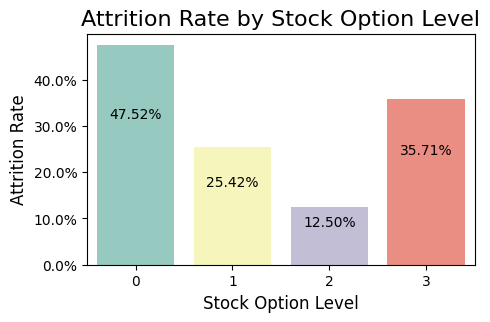

In [39]:
# StockOptionLevel
stock_option_group = target_group.groupBy("StockOptionLevel", "Attrition").count()
stock_option_pivot = stock_option_group.groupBy("StockOptionLevel").pivot("Attrition").agg(F.sum("count"))
stock_option_pivot = stock_option_pivot.withColumnRenamed("1", "Yes").withColumnRenamed("0", "No")
stock_option_pivot = stock_option_pivot.withColumn(
    "AttritionRate", col("Yes") / (col("Yes") + col("No"))).orderBy("StockOptionLevel")

stock_option_pivot.show()

# 시각화
stock_option_pandas = stock_option_pivot.toPandas()

plt.figure(figsize=(5, 3))
ax = sns.barplot(x="StockOptionLevel", y="AttritionRate", data=stock_option_pandas, palette="Set3")

# 막대 위에 퍼센트 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height * 2 / 3, f'{height * 100:.2f}%', ha='center')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.1f}%'))
plt.title("Attrition Rate by Stock Option Level", fontsize=16)
plt.xlabel("Stock Option Level", fontsize=12)
plt.ylabel("Attrition Rate", fontsize=12)
plt.show()


✏️ 초과 근무를 한 직원이 그렇지 않은 직원보다 이직률이 2배의 차이로 약 **67.92%**로 매우 높은 결과를 나타낸다.<br>
✏️ 주식 옵션 없음(Level = 0) 이 이직률이 약 **47.52%**로 가장 높고 중간 수준(Level = 1, Level = 2)의 주식 옵션 제공이 가장 효과적이나 최고 수준(Level = 3)의 경우 이직률이 다시 증가할 가능성이 있음을 시사한다.<br>
<br>
🔍 직업만족도와 연관하여 초과 근무를 줄이고 워라밸 개선 프로그램 도입을 통해 직원 만족도를 높일 필요가 있다. 주식 옵션 제공은 중간 수준(Level = 1, Level = 2)의 주식 옵션을 제공하는게 좋다. 

# 4. 머신러닝 모델 생성 및 예측

## 4.1 모델 생성

In [44]:
numeric_cols = [ "Age", "JobSatisfaction", "MonthlyIncome","StockOptionLevel", "YearsAtCompany", "PercentSalaryHike"]
string_cols = ["Attrition", "OverTime"]

In [49]:
# StringIndexer를 사용하여 범주형 컬럼을 숫자형으로 변환
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in string_cols]

# OneHotEncoder를 사용하여 범주형 컬럼을 원-핫 인코딩
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in string_cols]

# 문자형(인코딩) + 숫자형 피처를 겨람한 모델 입력 생성
assembler_inputs = [col+"_encoded" for col in string_cols] + numeric_cols
assembler_inputs = assembler_inputs[1:] #Attrition 제외
assembler = VectorAssembler(inputCols= assembler_inputs, outputCol="features")

# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# 파이프라인에 모든 스테이지 추가 - 
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(train_data)

# 데이터 변환
df_transformed = pipeline_model.transform(train_data)

# 로지스틱 회귀 모델
lr = LogisticRegression(featuresCol='features', labelCol='Attrition_index')

# 모델 훈련
lr_model = lr.fit(df_transformed)

# 테스트 데이터 변환
test_transformed = pipeline_model.transform(test_data)

## 4.2 예측

In [50]:
# 예측 수행
predictions = lr_model.transform(test_transformed)

# 예측 성능 평가
evaluator = BinaryClassificationEvaluator(labelCol='Attrition_index', rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(auc)

0.800830889540568


In [53]:
# Attrition, Attrition_Index: 실제 레이블 (No 0, Yes 1)
# prediction: 모델의 예츨 결과 (No 0, Yes 1)
# probability: 예측 확률 - 첫번째 No 일 확률, 두번째 Yes 일 확률
predictions.select('Attrition','Attrition_Index', 'prediction', 'probability').show(3,truncate=False)

+---------+---------------+----------+----------------------------------------+
|Attrition|Attrition_Index|prediction|probability                             |
+---------+---------------+----------+----------------------------------------+
|No       |0.0            |0.0       |[0.6880181091853963,0.3119818908146037] |
|Yes      |1.0            |1.0       |[0.3010204705979993,0.6989795294020007] |
|No       |0.0            |0.0       |[0.6365063460978769,0.36349365390212307]|
+---------+---------------+----------+----------------------------------------+
only showing top 3 rows



## 4.3 모델 분석 결과



✏️ 1차 AUC 값 = 0.6718963831867062 - 기본 예측보다는 나은 성능이지만 개선의 여지가 많음<br>
✏️ 2차 AUC 값 = 0.7806940371456519 <br>
✏️ AUC 값이 0.8008이므로, 이 모델은 좋은 성능을 보이는 것으로 평가.<br>

In [ ]:
spark.stop()